# Introduction

The goal of this project is the application of some of the machine learning techniques studied in the course of Big Data Computing. The chosen dataset was obtained from https://dati.comune.roma.it/ and preprocessed in order to make it usable. \
In the following, we'll go through:
- additional preprocessing
- a clustering task
- a classification task
- a time serie prediction task

Each section will be preceded by a small introduction.

Source code for the entire project can be found in [this repository](https://github.com/andry-dev/air).

# Dependencies and Reproducibility

In [1]:
#@title Install Pyspark

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 199 kB 51.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=506d72a0b25a78f7654b00cabbe3db4887545a260e262d7025f5cf8e6cf0f06f
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [3]:
#@title Install Folium, Plotly

!pip install folium plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Import dependencies


#General dependencies

import plotly.express as px
import numpy as np
from PIL import Image

#Geopandas
import folium

#Pyspark

import pyspark
import pyspark.pandas as ps
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import IntegerType,BooleanType,DateType

In [5]:
#@title Create Pyspark context

# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '4G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [6]:
#@title Run this to ensure reproducibility

#Note: this seed is used both by pyspark methods and neuralprophet
SEED = 413

# Data Preprocessing

In this section, we focus on loading the data and ensuring that PySpark automatically detects the right datatypes. The dataset is stored in the file aggregate.7z and is going to be automatically downloaded and extracted in the local session. \
After that, using Folium we are going to plot an interactive visualization of the accidents over a map of the city of Rome.

Note that this are not the only preprocessing steps that we had to go through. In fact, although the dataset can be downloaded in the "csv" format, it is divided into months. Furthermore, old entries in the dataset had different names for the columns, and some of the values were missing or didn't make sense.
In order to fix this, we joined each file and renamed the wrong columns. We also removed any typos from the entries (mainly by removing the entries themselves). This operation reduced the dataset by less than ~1%, so an acceptable loss (in our opinion, of course), and left us with roughly ~1.2mln entries. \
We also had to perform geocoding, to add coordinates in entries in which only the road in which the accidents happened appeared. This was achieved hosting a local copy of the nominatim API on a docker container, which was subsequently queried with road names to obtain the coordinates.


### Preprocessing scripts

These preprocessing scripts cannot run on Google Colab because they require a Nominatim instance up and running. We include them anyways for reference.

```python
#!/usr/bin/python3

import pandas as pd
from pathlib import Path, PurePath
import math
import argparse

import requests

from datetime import datetime


def geocode(street, ip='[::1]', port=8080):

    payload = {
        'street': street,
        'city': 'Roma',
        'format': 'geojson'
    }

    req = requests.get(f'http://{ip}:{port}/search', params=payload)

    return req.json()['features']


def extract_coordinates(matches):
    if len(matches) == 0:
        return [8888, 8888]

    return matches[0]['geometry']['coordinates']


def coordinates_legal(coordinates):
    # The street is wrong or obscure
    if coordinates[0] == 8888 and coordinates[1] == 8888:
        return False

    # 42.82125541042326, 11.774008325698063
    # 41.220224002262036, 14.029342839702176
    # Check if the coordinates are inside Lazio's bounds
    if (coordinates[0] <= 11.774008325698063 and coordinates[1] >= 42.82125541042326) or \
            (coordinates[0] >= 14.029342839702176 and coordinates[1] <= 41.220224002262036):
        return False

    return True


def extract_iso_date(value):
    value = value[:16] if len(value) >= 17 else value
    date = datetime.strptime(value, '%d/%m/%Y %H:%M')
    return '{}-{}-{}'.format(date.year, date.month, date.day)


def extract_hour(value):
    value = value[:16] if len(value) >= 17 else value
    date = datetime.strptime(value, '%d/%m/%Y %H:%M')
    return date.hour


def extract_month(value):
    value = value[:16] if len(value) >= 17 else value
    date = datetime.strptime(value, '%d/%m/%Y %H:%M')
    return date.month


def clean_data(df: pd.DataFrame):
    if 'Longitudine' in df.columns:
        df = df.rename(columns={'Longitudine': 'Longitude',
                                'Latitudine': 'Latitude'})

    invalid_rows = []

    for row in df.iterrows():
        missing_time = len(row[1]['DataOraIncidente']) <= 10
        if missing_time:
            invalid_rows.append(row[0])

        row_longitude = row[1]['Longitude']
        row_latitude = row[1]['Latitude']
        if (type(row_longitude) == float and math.isnan(row_longitude)) or \
           (type(row_latitude) == float and math.isnan(row_latitude)):

            query_str = row[1]['STRADA1']

            strada02 = row[1]['Strada02']

            if type(strada02) == str and 'civico' in strada02:
                civic_number = (row[1]['Chilometrica'])
                query_str += f' {civic_number}'

            found_matches = geocode(query_str)
            coordinates = extract_coordinates(found_matches)

            if not coordinates_legal(coordinates):
                invalid_rows.append(row[0])
                print(f'Invalid coordinates! Dropping row #{row[0]}')
                continue

            df.at[row[0], 'Longitude'] = coordinates[0]
            df.at[row[0], 'Latitude'] = coordinates[1]
        else:
            if (type(row_latitude) == str):
                df.at[row[0], 'Latitude'] = float(
                    row_latitude.replace(',', '.'))

            if (type(row_longitude) == str):
                df.at[row[0], 'Longitude'] = float(
                    row_longitude.replace(',', '.'))

    df = df[~((df['NUM_FERITI'] == 'Ore Diurne') |
              (df['NUM_FERITI'] == 'Sufficiente'))]

    df['Deadly'] = df['NUM_MORTI'] > 0
    df['Injured'] = df['NUM_FERITI'] > 0

    print(f'Dropping {len(invalid_rows)} rows with invalid coordinates.')
    df = df.drop(invalid_rows)
    df = df.drop(columns=['Localizzazione1', 'STRADA1',
                          'Localizzazione2', 'STRADA2', 'Strada02',
                          'Chilometrica', 'DaSpecificare', 'Confermato'])

    df['ISODate'] = df['DataOraIncidente'].apply(extract_iso_date)
    df['Month'] = df['DataOraIncidente'].apply(extract_month)
    df['Hour'] = df['DataOraIncidente'].apply(extract_hour)

    return df


def create_clean_dataframe(raw_filepath):
    print(raw_filepath)
    new_df = pd.read_csv(raw_filepath, delimiter=';',
                         on_bad_lines='error', verbose=False)

    parts = list(raw_filepath.parts)
    parts[2] = 'clean'
    new_path = PurePath()
    for part in parts:
        new_path = new_path / part
    print(new_path)

    new_df = clean_data(new_df)
    new_df.to_csv(new_path)

    return new_df


def read_csvs(directory):
    df = pd.DataFrame()
    for file in directory.glob('**/*.csv'):
        new_df = create_clean_dataframe(file)

        df = pd.concat((df, new_df), axis=0)

    return df


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('dir', type=Path)
    args = parser.parse_args()

    # create_clean_dataframe(directory)
    df = read_csvs(args.dir)
    df.to_csv(args.dir / '../aggregate.csv')
```

### Colab preprocessing

In [67]:
#@title Download and Unzip dataset

![[ ! -f aggregate.7z ]] && wget https://github.com/andry-dev/air/releases/download/v0.1/aggregate.7z
![[ ! -f aggregate.csv ]] && 7z x aggregate.7z

![[ ! -f source_code.tar.gz ]] && wget https://github.com/andry-dev/air/archive/refs/tags/v0.1.tar.gz -O source_code.tar.gz
!tar --strip-components 1 -xvf source_code.tar.gz air-0.1/models

air-0.1/models/
air-0.1/models/rf_injured/
air-0.1/models/rf_injured/bestModel/
air-0.1/models/rf_injured/bestModel/data/
air-0.1/models/rf_injured/bestModel/data/._SUCCESS.crc
air-0.1/models/rf_injured/bestModel/data/.part-00000-cdfdc2e6-1e7c-4704-96c5-60757c1dc6b0-c000.snappy.parquet.crc
air-0.1/models/rf_injured/bestModel/data/_SUCCESS
air-0.1/models/rf_injured/bestModel/data/part-00000-cdfdc2e6-1e7c-4704-96c5-60757c1dc6b0-c000.snappy.parquet
air-0.1/models/rf_injured/bestModel/metadata/
air-0.1/models/rf_injured/bestModel/metadata/._SUCCESS.crc
air-0.1/models/rf_injured/bestModel/metadata/.part-00000.crc
air-0.1/models/rf_injured/bestModel/metadata/_SUCCESS
air-0.1/models/rf_injured/bestModel/metadata/part-00000
air-0.1/models/rf_injured/bestModel/treesMetadata/
air-0.1/models/rf_injured/bestModel/treesMetadata/._SUCCESS.crc
air-0.1/models/rf_injured/bestModel/treesMetadata/.part-00000-fc73b370-0ba2-43e9-9af8-357c40dd0725-c000.snappy.parquet.crc
air-0.1/models/rf_injured/bestModel/

In [9]:
#@title Load dataset into memory
accidents_df = spark.read.csv("aggregate.csv", 
                               sep = ",",
                              header = True,
                              inferSchema = True)

In [10]:
#@title FIXME: Hacks to include in preprocessing.py

#Exclude coordinate outside Lazio
accidents_df = accidents_df.filter((41.220224002262036 < accidents_df['Latitude']) & (accidents_df['Latitude'] < 42.82125541042326))
accidents_df = accidents_df.filter((11.774008325698063 < accidents_df['Longitude']) & (accidents_df['Longitude'] < 14.029342839702176))

accidents_df = accidents_df.withColumn('Deadly', accidents_df['NUM_MORTI'] > 0)
accidents_df = accidents_df.withColumn('Injured', accidents_df['NUM_FERITI'] > 0)

accidents_df = accidents_df.withColumn('NUM_FERITI', accidents_df.NUM_FERITI.cast(IntegerType()))

accidents_df = accidents_df.drop('Unnamed: 37')

In [ ]:
#@title Visualize the csv's schema

accidents_df.printSchema()

In [ ]:
#@title Visualize first five rows

accidents_df.show(5, truncate=True)

In [ ]:
#@title Visualize a map of the accidents {run : "auto"}

#Obtain a map centered on Rome with Folium
map = folium.Map(location=(41.8974, 12.5022))
limit = 199 #@param {type:"slider", min:1, max:500} 


#Gather accidents' coordinates
accidents_coordinates = accidents_df['Latitude', 'Longitude'].limit(limit).collect()
for row in accidents_coordinates:

    point = [row['Latitude'], row['Longitude']]
    folium.Marker(location=point).add_to(map)

#Add coordinates popup
map.add_child(folium.LatLngPopup())

map

# Clustering

In this section, we focused on clustering the accidents w.r.t to their coordinates. This allowed us to group accidents into "zones" that we used later in the classification process. The best model was chosen by confronting the silhouette coefficient of each resulting clustering. In detail statistics at the end of the section can be visualized by running the corresponding cell.

In [ ]:
#@title Clustering functions

from pyspark.ml.feature import VectorAssembler

def compute_clusters(df, n_clusters, features=['Latitude', 'Longitude'], 
                     prediction_col='cluster', max_iterations=10):

  #SparkML expects columns to an instance of Linalg.Vector
  assembler = VectorAssembler().setInputCols(features).setOutputCol('features')
  assembled_df = assembler.transform(df)

  #Create KMeans instance
  kmeans = pyspark.ml.clustering.KMeans(k = n_clusters, featuresCol = 'features',
                                        predictionCol = prediction_col)

  #Set kmeans seed
  kmeans.setSeed(SEED)

  #Set maximum iterations
  kmeans.setMaxIter(max_iterations)
  #kmeans.getMaxIter()

  #Fit the model
  model = kmeans.fit(assembled_df)

  #Return the chosen distance measure (euclidean hopefully)
  #model.getDistanceMeasure()

  #Output a prediction for the first entry in the dataset
  model.predict(assembled_df.head().features)

  #Output centers of the model
  #centers = model.clusterCenters()
  #len(centers)

  #Output transformed df
  transformed = model.transform(assembled_df)
  return (model, transformed)


def evaluate_k_means(clusters, metric_name="silhouette", distance_measure="squaredEuclidean",
                     prediction_col="cluster"):
    from pyspark.ml.evaluation import ClusteringEvaluator

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(metricName=metric_name, distanceMeasure=distance_measure, predictionCol=prediction_col)

    score = evaluator.evaluate(clusters)
    del evaluator
    return score

def find_best_clustering(df, max_clusters, threshold=0.001):


  """Finds best clustering model w.r.t. the given metric and 
  returns both the model, the transformed dataframe and the scores"""

  # Evaluate for 2 clusters to get initial metrics
  best_model, best_transformed = compute_clusters(df, 5)
  best_score = evaluate_k_means(best_transformed)
  scores = [best_score]

  for k in range(10, max_clusters, 10):

      print("Using {} clusters".format(k))
      model, transformed = compute_clusters(df, k)
      score = evaluate_k_means(transformed)
      scores.append(score)
      if score > best_score:

        #Delete unused models to save space
        del best_model
        del best_transformed
        
        #Compute the difference between the previous and the new score
        delta = best_score - score

        best_score = score
        best_model = model
        best_transformed = transformed

        #if delta < threshold:
        #  break
        #else:
        del model
        del transformed

  return (best_model, best_transformed, scores)

In [ ]:
#@title Find best clustering

max_clusters = 101 #@param {type: "slider", min:2, max:500}
model, clustered_df, clustering_scores = find_best_clustering(accidents_df, max_clusters)

Using 10 clusters
Using 20 clusters
Using 30 clusters
Using 40 clusters
Using 50 clusters
Using 60 clusters
Using 70 clusters
Using 80 clusters
Using 90 clusters
Using 100 clusters


In [ ]:
#@title Visualize a map of the accidents per cluster {run : "auto"}

#Utility function
def assign_random_color(number):
  color_list =  ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
  return color_list[number % len(color_list)]

#Obtain a map centered on Rome with Folium
map = folium.Map(location=(41.8974, 12.5022))
limit = 27 #@param {type:"slider", min:1, max:10000} 

n_clusters = model.summary.k

for cluster_number in range(n_clusters):
  #Filter entries by cluster
  filtered_by_cluster = clustered_df.filter(clustered_df['cluster'] == cluster_number)

  #Gather accidents' coordinates
  coordinates_list = filtered_by_cluster['Latitude', 'Longitude'].limit(limit).collect()

  #Assign color for the markers
  color = assign_random_color(cluster_number)

  for row in coordinates_list:
      point = [row['Latitude'], row['Longitude']]
      folium.Marker(location=point, icon=folium.Icon(color=color)).add_to(map)

  #Add coordinates popup
  map.add_child(folium.LatLngPopup())

map

In [ ]:
#@title Print Model Statistics
fig = px.line(clustering_scores,
              title='Clustering Scores')

fig.show()

summary = model.summary
print("Model statistics: nr. clusters {}, size of clusters{}, training cost {}".format(summary.k,
                                                                            summary.clusterSizes,
                                                                            summary.trainingCost))

Model statistics: nr. clusters 70, size of clusters[31612, 12398, 7137, 10137, 32382, 37553, 3497, 3374, 11518, 41184, 13325, 1827, 10189, 21661, 4310, 17667, 47100, 3319, 28691, 10214, 11929, 335, 31979, 14494, 20588, 31708, 12702, 16621, 24128, 33018, 34671, 4373, 6610, 12870, 10760, 10497, 3028, 24786, 5443, 4043, 24875, 1608, 20831, 92, 49388, 189, 42926, 843, 9957, 43549, 59459, 25349, 1346, 20988, 25263, 2917, 22645, 6132, 7147, 55960, 8716, 35272, 7155, 7388, 20659, 30415, 703, 26321, 1064, 300], training cost 237.47075580334953


# Feature engineering and classification

In this section, we focused on understanding whether it was possible to predict the outcome of an accident (e.g. injury, death) with the information we had. In order to do this, we first assembled the columns into a suitable format and, after dropping unnecessary columns, trained the chosen model. We used the CrossValidator from PySpark's library, with AUROC as the target metric. On top of that, we performed additional measurements on a split of the dataset we created earlier in order to obtain additional info on the result, given the unbalances in the dataset (deaths). 

Note that, while it would have possible to use something like SMOTE to create additional data, we decided to instead use weights that encouraged the model to pay more attention to errors on the target class. The reason behind this choice was mainly that creating new entries of accidents would greatly decrease the "realism" of the dataset, and that using SMOTE requires lots of memory. Furthermore, there is no official implementation of SMOTE in pyspark's APIs, only third party code.

In [ ]:
#@title Remove unnecessary columns

to_drop =  ['features','Protocollo', 'DataOraIncidente', 'Gruppo','NUM_MORTI', 'NUM_FERITI', 'NUM_RISERVATA', 'NUM_ILLESI', 'Confermato', 'Progressivo',
                                'Deceduto', 'DecedutoDopo', 'DaSpecificare', 'TipoLesione', 'ISODate']
for cols in to_drop:
    clustered_df =  clustered_df.drop(cols)  

clustered_df.printSchema()

root
 |-- NaturaIncidente: string (nullable = true)
 |-- particolaritastrade: string (nullable = true)
 |-- TipoStrada: string (nullable = true)
 |-- FondoStradale: string (nullable = true)
 |-- Pavimentazione: string (nullable = true)
 |-- Segnaletica: string (nullable = true)
 |-- CondizioneAtmosferica: string (nullable = true)
 |-- Traffico: string (nullable = true)
 |-- Visibilita: string (nullable = true)
 |-- Illuminazione: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- TipoVeicolo: string (nullable = true)
 |-- StatoVeicolo: string (nullable = true)
 |-- TipoPersona: string (nullable = true)
 |-- Sesso: string (nullable = true)
 |-- CinturaCascoUtilizzato: string (nullable = true)
 |-- Airbag: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Deadly: boolean (nullable = true)
 |-- Injured: boolean (nullable = true)
 |-- cluster: integer (nullable = false)



In [ ]:
#@title Assembling mixed dataframe

#Solution from https://stackoverflow.com/questions/67753426/pyspark-combining-output-of-two-vectorassemblers

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

numerical_columns = ['Longitude', 'Latitude']
num_feat_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

cat_columns = [x for x in clustered_df.columns if x not in numerical_columns and x not in ["Deadly", "Injured"]]
cat_indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid = "skip")
    for c in cat_columns
]
encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in cat_indexers
]
assemblerCateg = VectorAssembler(
    inputCols = [encoder.getOutputCol() for encoder in encoders],
    outputCol = "categorical_features"
)

assemblerAll = VectorAssembler(inputCols= ["numerical_features", "categorical_features"], outputCol="features")
pipeline = Pipeline(stages = [num_feat_assembler] + cat_indexers + encoders + [assemblerCateg] + [assemblerAll])

assembled_df = pipeline.fit(clustered_df).transform(clustered_df)
assembled_df.show(5, truncate=False)

+--------------------------------------------------+-------------------+---------------+-----------------+--------------+-----------+---------------------+--------+----------+-------------+----------+----------+-------------------+-----------------------------+-----------+-----+----------------------+-----------+-----+----+------+-------+-------+-----------------------+-----------------------+---------------------------+------------------+---------------------+----------------------+-------------------+-----------------------------+----------------+------------------+---------------------+-------------------+--------------------+-------------------+-------------+------------------------------+--------------+-------------+------------+---------------+-------------------------------+-----------------------------------+--------------------------+-----------------------------+------------------------------+---------------------------+-------------------------------------+------------------

In [ ]:
#@title Define training targets

class TrainingTarget():
    def __init__(self, weight_col, label_col):
        self.weight_col = weight_col
        self.label_col = label_col

deadly_training_target = TrainingTarget(weight_col = 'weight_d', label_col = 'Deadly')
injured_training_target = TrainingTarget(weight_col = 'weight_i', label_col = 'Injured')

In [ ]:
#@title Add weights to classes

#Dataset is heavily unbalanced w.r.t to deaths
deadly_weight = 1 - assembled_df.filter(assembled_df[deadly_training_target.label_col]).count() / assembled_df.count()
non_deadly_weight = 1 - deadly_weight

#Even if the ratio for injuries is lower we still apply a weight to balance
injured_weigth = 1 - assembled_df.filter(assembled_df[injured_training_target.label_col]).count() / assembled_df.count()
non_injured_weight = 1 - injured_weigth

assembled_df = assembled_df.withColumn(deadly_training_target.weight_col, \
                                       when(assembled_df[deadly_training_target.label_col], deadly_weight) \
                                           .otherwise(non_deadly_weight))
assembled_df = assembled_df.withColumn(injured_training_target.weight_col, \
                                       when(assembled_df[injured_training_target.label_col], injured_weigth) \
                                           .otherwise(non_injured_weight))
assembled_df.printSchema()

In [ ]:
#@title Train/Test Split

assembled_df = assembled_df.withColumn(deadly_training_target.label_col, \
                                       assembled_df.Deadly.cast(IntegerType()))
assembled_df = assembled_df.withColumn(injured_training_target.label_col, \
                                       assembled_df.Injured.cast(IntegerType()))

training_df, test_df = assembled_df.randomSplit([0.90, 0.10], seed=SEED)

print('Training data size: {}\nTest data size: {}'.format(training_df.count(), test_df.count()))

Training data size: 811202
Test data size: 89763


In [ ]:
#@title Training/Validation methods 

from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def build_model_parameters(classifier_str, target: TrainingTarget):
    
    if classifier_str=="random_forest":
      classifier = RandomForestClassifier()
      grid = ParamGridBuilder() \
                  .baseOn({classifier.labelCol: target.label_col,
                          classifier.weightCol: target.weight_col}) \
                  .addGrid(classifier.numTrees, [2, 3, 5, 12, 24]) \
                  .addGrid(classifier.maxDepth, [15, 20, 25, 30]) \
                  .build()
      
      return (classifier, grid)
    else:
      classifier = LogisticRegression()
      grid = ParamGridBuilder() \
                  .baseOn({classifier.labelCol: target.label_col,
                          classifier.weightCol: target.weight_col}) \
                  .addGrid(classifier.threshold, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) \
                  .build()
      
      return (classifier, grid)


def get_model(df, target: TrainingTarget, name: str, classifier="logistic", force_recompute=False):
    from pathlib import Path

    path = "models/{}_{}".format(classifier, name)
    
    model_dir = Path(path)
    
    if model_dir.exists() and model_dir.is_dir() and not force_recompute:
        print("Loading model from path: {}".format(path))
        cvModelRead = CrossValidatorModel.load(path)
        return cvModelRead
    else:
        print("Can't find model in path '{}', training instead".format(path))
        estimator, param_grid = build_model_parameters(classifier, target)
        evaluator = BinaryClassificationEvaluator(labelCol=target.label_col)
        cv = CrossValidator(estimator=estimator, numFolds=5, estimatorParamMaps=param_grid,
                            evaluator=evaluator, parallelism=2, seed=SEED)

        cvModel = cv.fit(df)
        cvModel.write().overwrite().save(path)
        return cvModel

In [ ]:
#@title Train the model

cvModel = get_model(training_df,
                    name='deadly',
                    target=deadly_training_target,
                    classifier='random_forest',
                    force_recompute=False)

Can't find model in path 'model', training instead


In [ ]:
#@title Output example predictions

preds = cvModel.transform(test_df).select('Deadly', 'prediction')
preds.filter((preds.prediction == 0.0) & (preds.Deadly == 1)).show(5)

+------+----------+
|Deadly|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
+------+----------+
only showing top 5 rows



In [ ]:
#@title Compute extra metrics 

tp = preds.filter((preds['Deadly'] == 1) & (preds['prediction'] == 1.0)).count()
fp = preds.filter((preds['Deadly'] == 0) & (preds['prediction'] == 1.0)).count()
fn = preds.filter((preds['Deadly'] == 1) & (preds['prediction'] == 0.0)).count()
tn = preds.filter((preds['Deadly'] == 0) & (preds['prediction'] == 0.0)).count()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn)
f1 = 2 * (precision  * recall) / (precision + recall)

print('Recall: {}\nPrecision: {}\nAccuracy: {}\nF1: {}'.format(recall, precision, accuracy, f1))

In [ ]:
#@title Compute feature importances from the best model from CV

def compute_feature_importances(df, model):
    import pandas as pd

    df = model.transform(df)

    pandasDF = pd.DataFrame(df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
    feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 
    feature_dict_broad = sc.broadcast(feature_dict)
    importances = model.featureImportances
    importances_array = []
    for k in feature_dict:
        importances_array.append((importances[k], feature_dict[k]))

    importances_array.sort(key=(lambda x: x[0]), reverse=True)

    return importances_array

feature_importances = compute_feature_importances(test_df, cvModel.bestModel)
feature_importances

[(0.07037253297200255,
  'categorical_features_NaturaIncidente_indexed_encoded_Investimento di pedone'),
 (0.05065891102084417, 'numerical_features_Latitude'),
 (0.04853457296865546, 'numerical_features_Longitude'),
 (0.035994631238133526,
  'categorical_features_NaturaIncidente_indexed_encoded_Scontro frontale fra veicoli in marcia'),
 (0.035530301241613396,
  'categorical_features_NaturaIncidente_indexed_encoded_Scontro laterale fra veicoli in marcia'),
 (0.021343797030940168,
  'categorical_features_Illuminazione_indexed_encoded_Ore Diurne'),
 (0.02086297550613804,
  'categorical_features_Airbag_indexed_encoded_Inesploso'),
 (0.018365326419692136,
  'categorical_features_TipoVeicolo_indexed_encoded_Autovettura privata'),
 (0.017095558168151132,
  'categorical_features_particolaritastrade_indexed_encoded_Incrocio'),
 (0.016707905466632828,
  'categorical_features_NaturaIncidente_indexed_encoded_Tamponamento'),
 (0.016102186384761658,
  'categorical_features_TipoStrada_indexed_encoded

# Time series

To finish off, we leveraged the power of NeuralProphet in order to predict the trend of accidents within a 1 year window. NeuralProphet was created by Facebook (https://neuralprophet.com/html/index.html) in order to provide a more interpretable model to create time predictions. In fact, NeuralProphet model leverages not only statistics but also the power of neural network, with a tradeoff in explainability (e.g. the more we use the network, the less the interpretability). 

The great thing about NP is that it also allows us to visualize how each component of the model contributed to the final output, as shown in the respective cells below. It is also possible to insert local holidays or special events (the covid-19 quarantine in our case).

Other cool features include auto-regression, auto-imputation (provided not too many values are missing) and so on.

In [ ]:
#@title Install neuralprophet

!pip install neuralprophet[live]

In [50]:
#@title Training utils

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

set_random_seed(SEED)

class TimeSerieResult():
    def __init__(self, model, metrics, forecast, df_test):
        self.model = model
        self.metrics = metrics
        self.forecast = forecast
        self.df_test = df_test

def generate_forecast(df, frequency='auto'):
    df = df.select(['ISODate', 'Protocollo']) \
           .groupBy(['ISODate', 'Protocollo']) \
           .count() \
           .groupBy('ISODate') \
           .count() \
           .withColumnRenamed('ISODate', 'ds') \
           .withColumnRenamed('count', 'y') \
           .toPandas()
    
    events_df = df.copy(deep=True)
    events_df['event'] = 'quarantine'
    events_df = events_df.drop(columns=['y'])
    events_df = events_df[(events_df['ds'] >= '2020-3-9') & (events_df['ds'] < '2020-5-1')]
        
    #MSE is necessary as RMSE is more influenced by outliers (the quarantine event we add), as explained in NeuralProphet docs
    model = NeuralProphet(epochs=120, 
                          learning_rate=0.001, 
                          loss_func='MSE', 
                          daily_seasonality=False, 
                          num_hidden_layers=4, 
                          d_hidden=32, 
                          )
    model.add_country_holidays('IT')
    model.add_events(['quarantine'])
    history_df = model.create_df_with_events(df, events_df)

    df_train, df_test = model.split_df(history_df, valid_p = 1.0/12, freq=frequency)
    metrics = model.fit(df_train, validation_df=df_test, progress='plot', freq=frequency)

    future = model.make_future_dataframe(df=history_df,
                                         events_df = events_df,
                                         periods=365,
                                         n_historic_predictions=True)
    forecast = model.predict(df=future)
    print(future.tail(20))
     
    return TimeSerieResult(model=model, metrics=metrics, forecast=forecast, df_test=df_test)

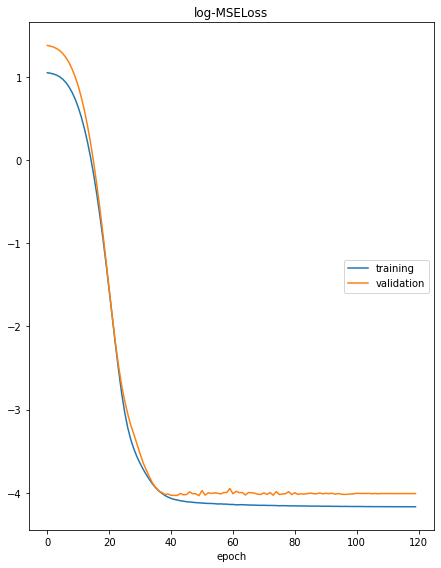

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.983% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.984% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


log-MSELoss
	training         	 (min:   -4.167, max:    1.051, cur:   -4.167)
	validation       	 (min:   -4.034, max:    1.378, cur:   -4.009)


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.984% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


             ds     y  quarantine
6097 2022-09-11  None         0.0
6098 2022-09-12  None         0.0
6099 2022-09-13  None         0.0
6100 2022-09-14  None         0.0
6101 2022-09-15  None         0.0
6102 2022-09-16  None         0.0
6103 2022-09-17  None         0.0
6104 2022-09-18  None         0.0
6105 2022-09-19  None         0.0
6106 2022-09-20  None         0.0
6107 2022-09-21  None         0.0
6108 2022-09-22  None         0.0
6109 2022-09-23  None         0.0
6110 2022-09-24  None         0.0
6111 2022-09-25  None         0.0
6112 2022-09-26  None         0.0
6113 2022-09-27  None         0.0
6114 2022-09-28  None         0.0
6115 2022-09-29  None         0.0
6116 2022-09-30  None         0.0


In [51]:
#@title Generate forecast for any type of accident

accidents_ts = generate_forecast(accidents_df)

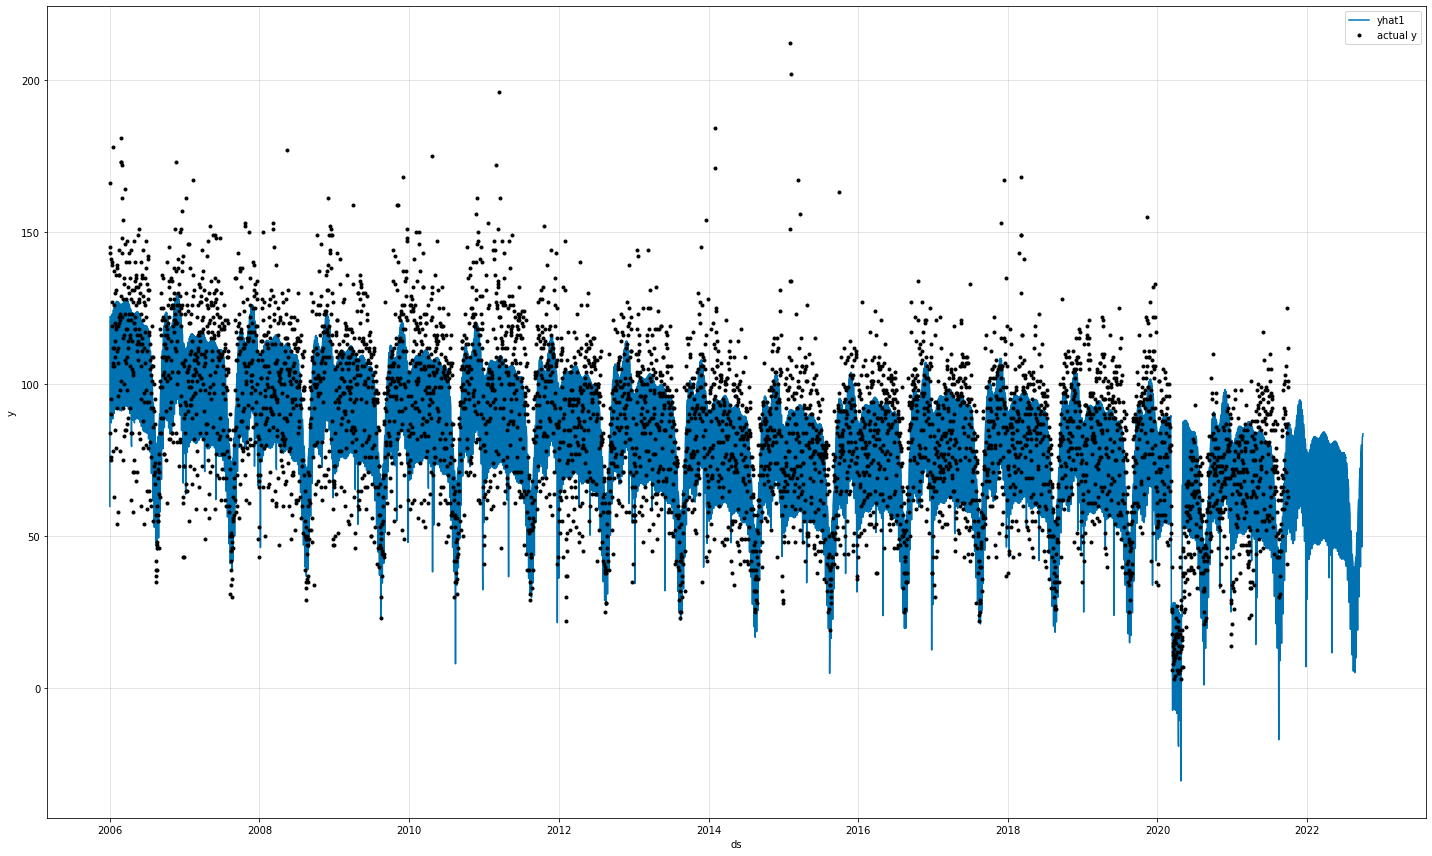

In [54]:
#@title Plot forecast for any type of accident
_ = accidents_ts.model.plot(accidents_ts.forecast, figsize=(20, 12))

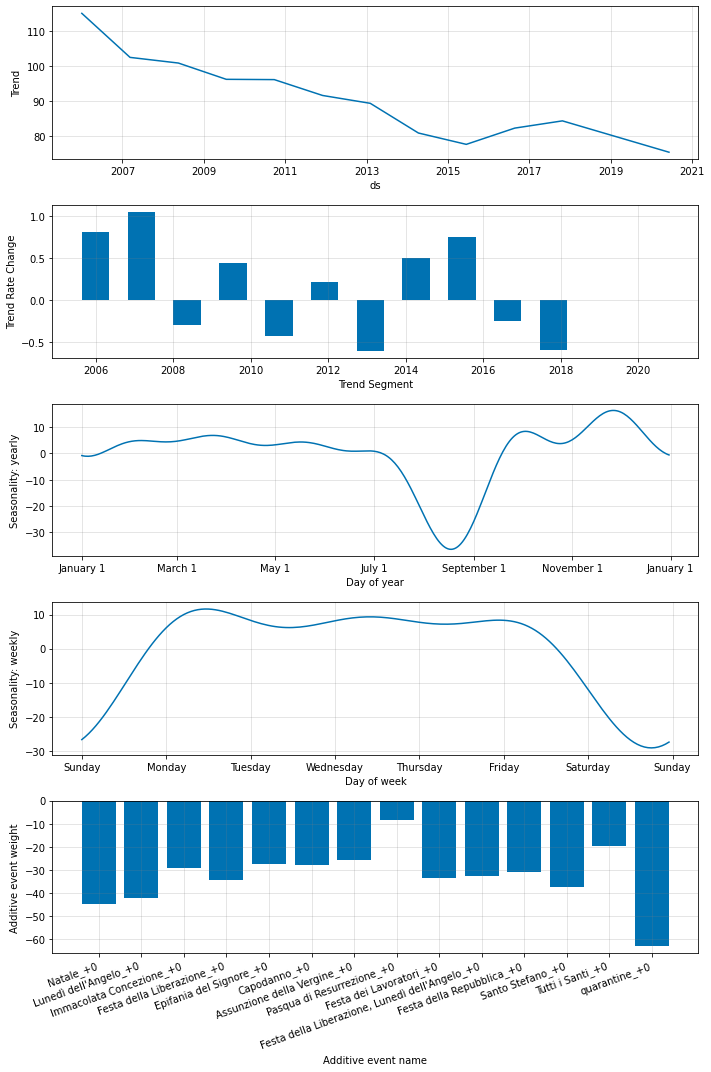

In [56]:
#@title Plot forecast parameters for any type of accident

_ = accidents_ts.model.plot_parameters()

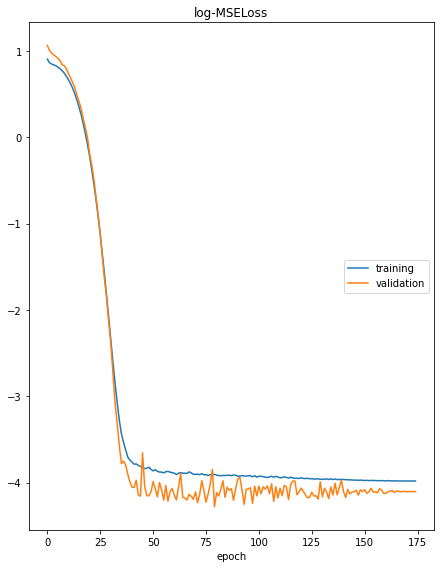

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.965% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.965% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.965% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.965% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.965% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.965% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to maj

log-MSELoss
	training         	 (min:   -3.982, max:    0.904, cur:   -3.982)
	validation       	 (min:   -4.279, max:    1.063, cur:   -4.104)


In [ ]:
#@title Generate forecast for accidents with injured

accidents_injured_ts = generate_forecast(accidents_df.filter(accidents_df['Injured'] == 1))

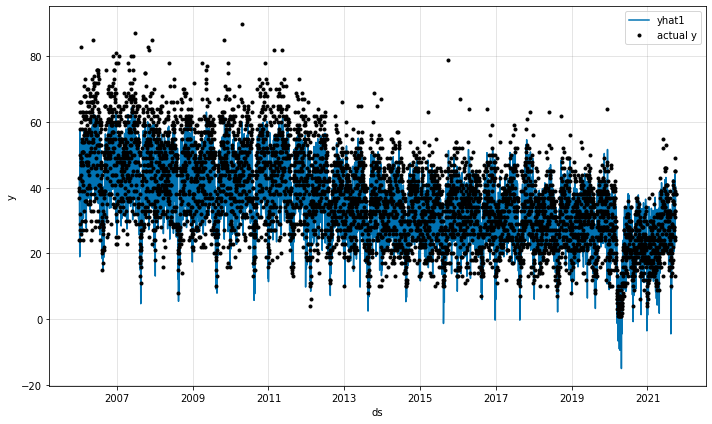

In [ ]:
#@title Plot forecast for accidents with injured

_ = accidents_injured_ts.model.plot(accidents_injured_ts.forecast)

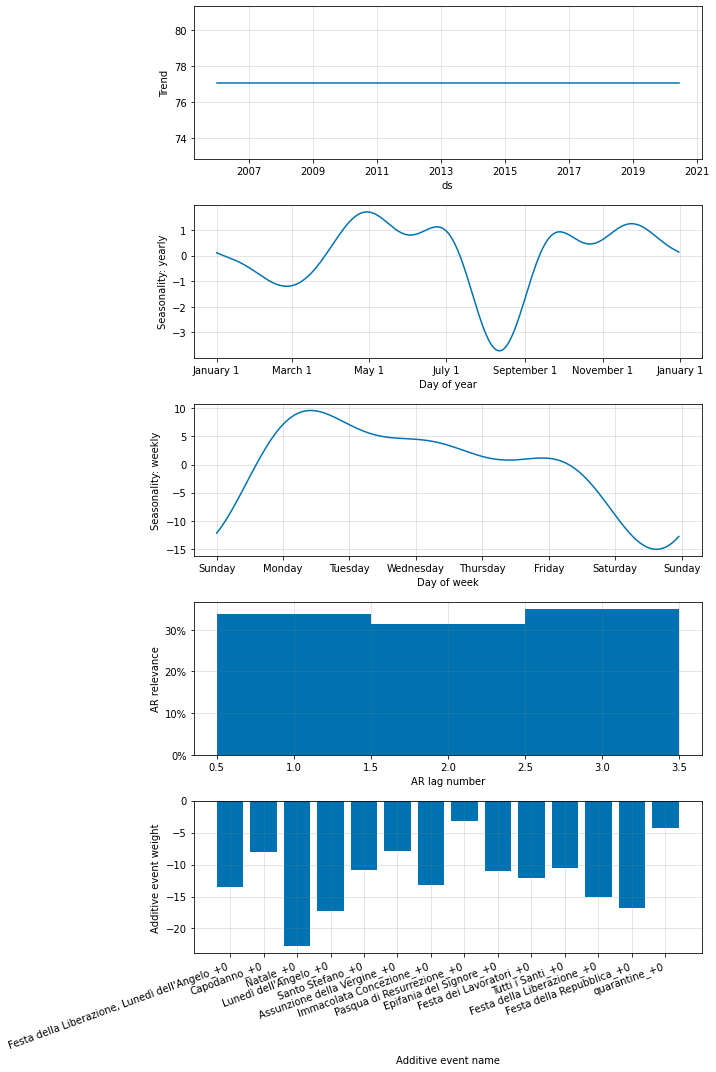

In [ ]:
#@title Plot forecast parameters for accidents with injured

_ = accidents_injured_ts.model.plot_parameters()

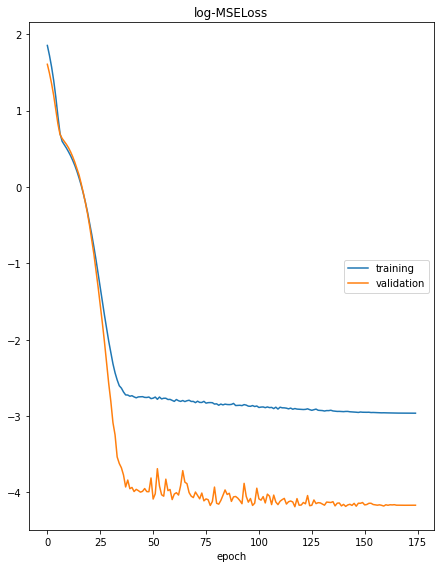

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 32.613% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 32.613% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 32.65% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 32.65% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 32.

log-MSELoss
	training         	 (min:   -2.962, max:    1.853, cur:   -2.962)
	validation       	 (min:   -4.187, max:    1.607, cur:   -4.167)


In [ ]:
#@title Generate forecast for accidents with deaths 

accidents_deadly_ts = generate_forecast(accidents_df.filter(accidents_df['Deadly'] == 1), frequency='D')

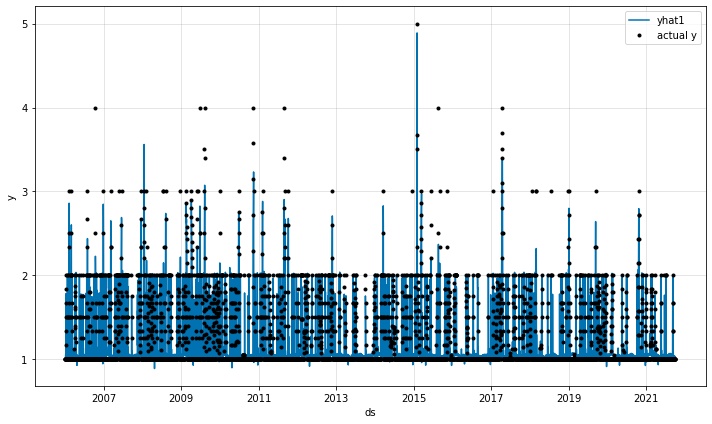

In [ ]:
#@title Plot forecast for accidents with deaths

_ = accidents_deadly_ts.model.plot(accidents_deadly_ts.forecast)

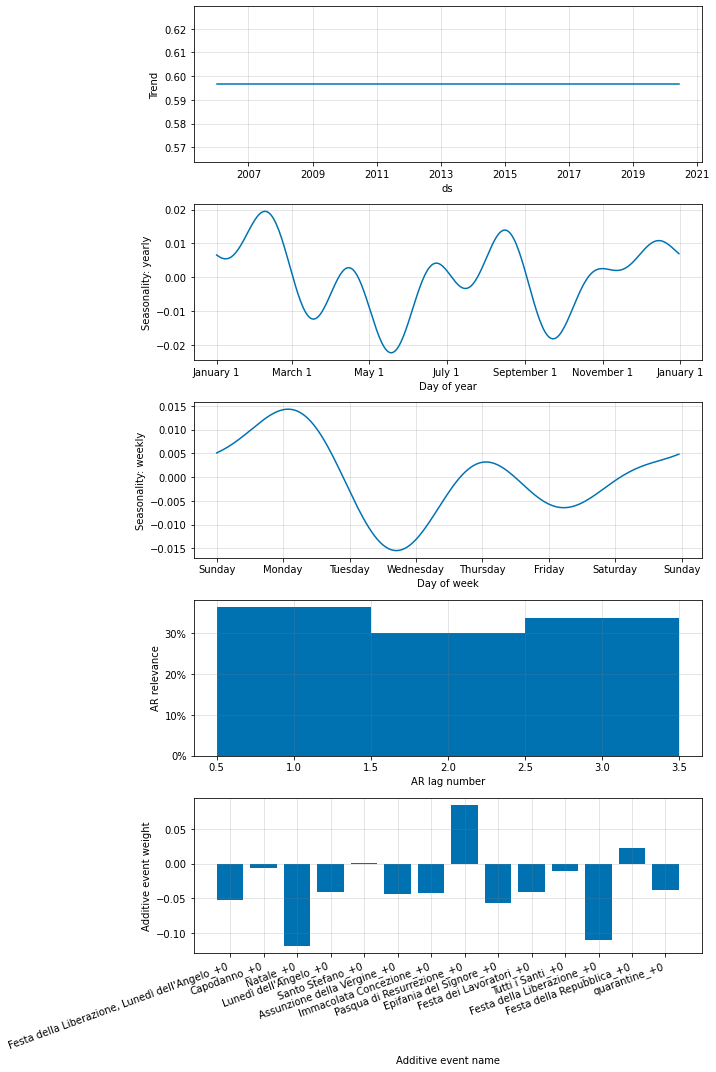

In [ ]:
#@title Plot forecast parameters for accidents with deaths

_ = accidents_deadly_ts.model.plot_parameters()